## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv", usecols=columns)

df.reviews_per_month = df.reviews_per_month.fillna(0)

<AxesSubplot:xlabel='price', ylabel='Count'>

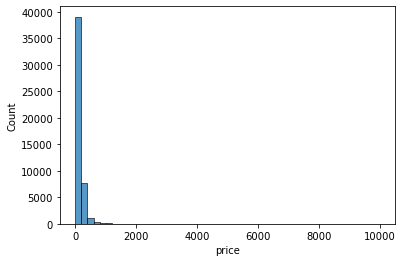

In [3]:
sns.histplot(df.price, bins=50)

In [4]:
df.price = np.log1p(df.price)

<AxesSubplot:xlabel='price', ylabel='Count'>

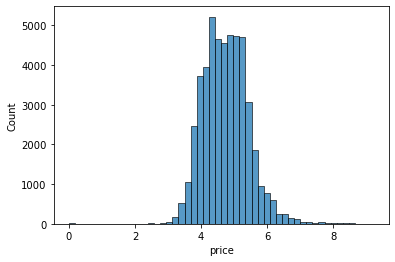

In [5]:
sns.histplot(df.price, bins=50)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [7]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

Now, use `DictVectorizer` to turn train and validation into matrices:

In [8]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [9]:
del df_train["price"]
del df_val["price"]
del df_test["price"]

In [10]:
df_train.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
385,Queens,40.76434,-73.92132,Entire home/apt,4,30,0.32,1,363
33147,Brooklyn,40.73442,-73.95854,Private room,5,2,0.16,1,0
33881,Brooklyn,40.66359,-73.99487,Entire home/apt,1,33,2.75,5,113
37208,Brooklyn,40.63766,-74.02626,Private room,3,1,0.12,2,362
7485,Brooklyn,40.65118,-74.00842,Private room,2,0,0.00,2,365


In [11]:
dv = DictVectorizer(sparse = False)

train_dicts = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [44]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [45]:
from sklearn.tree import export_text

In [48]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [56]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [57]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [58]:
mean_squared_error(y_val, y_pred)

0.21304061561242482

In [59]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [60]:
rmse(y_val, y_pred)

0.46156323035140573

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [63]:
score = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score.append((n, rmse(y_val, y_pred)))

In [65]:
df_scores = pd.DataFrame(score, columns = ["n_estimators", "rmse"])

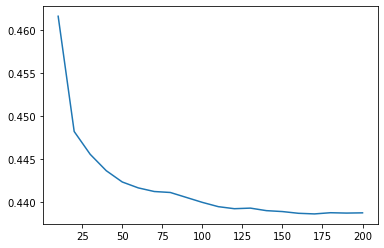

In [66]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [68]:
score_4 = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, 
                                   max_depth=d, 
                                   random_state=1, 
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score_4.append((n, d, rmse(y_val, y_pred)))
df_score4 = pd.DataFrame(score_4, columns=["n_estimators", "max_depth", "rmse"])

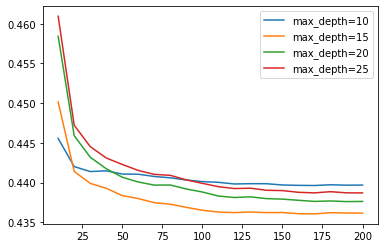

In [69]:
for d in [10, 15, 20, 25]:
    df_subset = df_score4[df_score4.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [70]:
rf = RandomForestRegressor(n_estimators=10, 
                                   max_depth=20, 
                                   random_state=1, 
                                   n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [83]:
feature_importance = []
fn = dv.feature_names_
fi = rf.feature_importances_
for i in range(0, len(fi)):
    feature_importance.append((fn[i], fi[i]))
columns = ["feature_names", "feature_importance"]
df_feature_importance = pd.DataFrame(feature_importance, columns=columns)

In [86]:
df_feature_importance.sort_values(by="feature_importance")

,feature_names,feature_importance
9,neighbourhood_group=Staten Island,0.000084
5,neighbourhood_group=Bronx,0.000265
6,neighbourhood_group=Brooklyn,0.000966
8,neighbourhood_group=Queens,0.001166
13,room_type=Private room,0.004032
14,room_type=Shared room,0.005023
1,calculated_host_listings_count,0.030102
7,neighbourhood_group=Manhattan,0.034047
10,number_of_reviews,0.041594
4,minimum_nights,0.053252


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [13]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [12]:
import xgboost as xgb

Now change `eta` first to `0.1` and then to `0.01`

In [14]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [15]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)

In [16]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [21]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [29]:
scores = {}

Run the below cell multiple times with different values. In this case, value for **eta** was changed

In [35]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [36]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

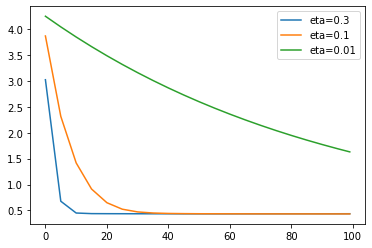

In [38]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
    plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

